##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Training with Orbit

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tfmodels/orbit"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/models/blob/master/docs/orbit/index.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/models/blob/master/docs/orbit/index.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/models/docs/orbit/index.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>

</table>

This example will work through fine-tuning a BERT model using the [Orbit](https://www.tensorflow.org/api_docs/python/orbit) training library.

Orbit is a flexible, lightweight library designed to make it easy to write [custom training loops](https://www.tensorflow.org/tutorials/distribute/custom_training) in TensorFlow. Orbit handles common model training tasks such as saving checkpoints, running model evaluations, and setting up summary writing, while giving users full control over implementing the inner training loop. It integrates with `tf.distribute` and supports running on different device types (CPU, GPU, and TPU).

Most examples on [tensorflow.org](https://www.tensorflow.org/) use custom training loops or  [model.fit()](https://www.tensorflow.org/api_docs/python/tf/keras/Model) from Keras. Orbit is a good alternative to `model.fit` if your model is complex and your training loop requires more flexibility, control, or customization. Also, using Orbit can simplify the code when there are many different model architectures that all use the same custom training loop.

This tutorial focuses on setting up and using Orbit, rather than details about BERT, model construction, and data processing. For more in-depth tutorials on these topics, refer to the following tutorials:

* [Fine tune BERT](https://www.tensorflow.org/text/tutorials/fine_tune_bert) - which goes into detail on these sub-topics.
* [Fine tune BERT for GLUE on TPU](https://www.tensorflow.org/text/tutorials/bert_glue) - which generalizes the code to run any BERT configuration on any [GLUE](https://www.tensorflow.org/datasets/catalog/glue) sub-task, and runs on TPU.

## Install the TensorFlow Models package

Install and import the necessary packages, then configure all the objects necessary for training a model.



In [2]:
!pip install -q opencv-python
!pip install tensorflow>=2.9.0 tf-models-official

The `tf-models-official` package contains both the `orbit` and `tensorflow_models` modules.

In [3]:
import tensorflow_models as tfm
import orbit

2023-10-17 11:55:57.421119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 11:55:57.421164: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 11:55:57.421203: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Setup for training

This tutorial does not focus on configuring the environment, building the model and optimizer, and loading data. All these techniques are covered in more detail in the [Fine tune BERT](https://www.tensorflow.org/text/tutorials/fine_tune_bert) and [Fine tune BERT with GLUE](https://www.tensorflow.org/text/tutorials/bert_glue) tutorials.

To view how the training is set up for this tutorial, expand the rest of this section.

  <!-- <div class="tfo-display-only-on-site"><devsite-expandable>
  <button type="button" class="button-red button expand-control">Expand Section</button> -->

### Import the necessary packages

Import the BERT model and dataset building library from [Tensorflow Model Garden](https://github.com/tensorflow/models).

In [4]:
import glob
import os
import pathlib
import tempfile
import time

import numpy as np

import tensorflow as tf

In [5]:
from official.nlp.data import sentence_prediction_dataloader
from official.nlp import optimization

### Configure the distribution strategy

While `tf.distribute` won't help the model's runtime if you're running on a single machine or GPU, it's necessary for TPUs. Setting up a distribution strategy allows you to use the same code regardless of the configuration.

In [6]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
  tf.config.experimental_connect_to_cluster(resolver)
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.TPUStrategy(resolver)
else:
  strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])


2023-10-17 11:56:02.076511: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


For more information about the TPU setup, refer to the [TPU guide](https://www.tensorflow.org/guide/tpu).

### Create a model and an optimizer

In [7]:
max_seq_length = 128
learning_rate = 3e-5
num_train_epochs = 3
train_batch_size = 32
eval_batch_size = 64

train_data_size = 3668
steps_per_epoch = int(train_data_size / train_batch_size)

train_steps = steps_per_epoch * num_train_epochs
warmup_steps = int(train_steps * 0.1)

print("train batch size: ", train_batch_size)
print("train epochs:     ", num_train_epochs)
print("steps_per_epoch:  ", steps_per_epoch)

train batch size:  32
train epochs:      3
steps_per_epoch:   114


In [8]:
model_dir = pathlib.Path(tempfile.mkdtemp())
print(model_dir)

/tmpfs/tmp/tmpjbwlp79l



Create a BERT Classifier model and a simple optimizer. They must be created inside `strategy.scope` so that the variables can be distributed. 

In [9]:
with strategy.scope():
  encoder_network = tfm.nlp.encoders.build_encoder(
      tfm.nlp.encoders.EncoderConfig(type="bert"))
  classifier_model = tfm.nlp.models.BertClassifier(
      network=encoder_network, num_classes=2)

  optimizer = optimization.create_optimizer(
      init_lr=3e-5,
      num_train_steps=steps_per_epoch * num_train_epochs,
      num_warmup_steps=warmup_steps,
      end_lr=0.0,
      optimizer_type='adamw')

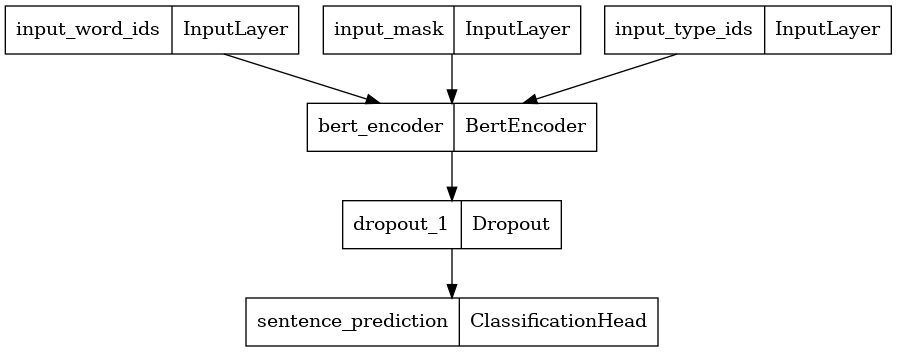

In [10]:
tf.keras.utils.plot_model(classifier_model)

### Initialize from a Checkpoint

In [11]:
bert_dir = 'gs://cloud-tpu-checkpoints/bert/v3/uncased_L-12_H-768_A-12/'
tf.io.gfile.listdir(bert_dir)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [12]:
bert_checkpoint = bert_dir + 'bert_model.ckpt'

In [13]:
def init_from_ckpt_fn():
  init_checkpoint = tf.train.Checkpoint(**classifier_model.checkpoint_items)
  with strategy.scope():
    (init_checkpoint
     .read(bert_checkpoint)
     .expect_partial()
     .assert_existing_objects_matched())

In [14]:
with strategy.scope():
  init_from_ckpt_fn()


To use Orbit, create a `tf.train.CheckpointManager` object.

In [15]:
checkpoint = tf.train.Checkpoint(model=classifier_model, optimizer=optimizer)
checkpoint_manager = tf.train.CheckpointManager(
    checkpoint,
    directory=model_dir,
    max_to_keep=5,
    step_counter=optimizer.iterations,
    checkpoint_interval=steps_per_epoch,
    init_fn=init_from_ckpt_fn)

### Create distributed datasets

As a shortcut for this tutorial, the [GLUE/MPRC dataset](https://www.tensorflow.org/datasets/catalog/glue#gluemrpc) has been converted to a pair of [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) files containing serialized `tf.train.Example` protos.

The data was converted using [this script](https://github.com/tensorflow/models/blob/r2.9.0/official/nlp/data/create_finetuning_data.py).



In [16]:
train_data_path = "gs://download.tensorflow.org/data/model_garden_colab/mrpc_train.tf_record"
eval_data_path = "gs://download.tensorflow.org/data/model_garden_colab/mrpc_eval.tf_record"

def _dataset_fn(input_file_pattern, 
                global_batch_size, 
                is_training, 
                input_context=None):
  data_config = sentence_prediction_dataloader.SentencePredictionDataConfig(
    input_path=input_file_pattern,
    seq_length=max_seq_length,
    global_batch_size=global_batch_size,
    is_training=is_training)
  return sentence_prediction_dataloader.SentencePredictionDataLoader(
      data_config).load(input_context=input_context)

train_dataset = orbit.utils.make_distributed_dataset(
    strategy, _dataset_fn, input_file_pattern=train_data_path,
    global_batch_size=train_batch_size, is_training=True)
eval_dataset = orbit.utils.make_distributed_dataset(
    strategy, _dataset_fn, input_file_pattern=eval_data_path,
    global_batch_size=eval_batch_size, is_training=False)



### Create a loss function


In [17]:
def loss_fn(labels, logits):
  """Classification loss."""
  labels = tf.squeeze(labels)
  log_probs = tf.nn.log_softmax(logits, axis=-1)
  one_hot_labels = tf.one_hot(
      tf.cast(labels, dtype=tf.int32), depth=2, dtype=tf.float32)
  per_example_loss = -tf.reduce_sum(
      tf.cast(one_hot_labels, dtype=tf.float32) * log_probs, axis=-1)
  return tf.reduce_mean(per_example_loss)

 </devsite-expandable></div>

## Controllers, Trainers and Evaluators

When using Orbit, the `orbit.Controller` class drives the training. The Controller handles the details of distribution strategies, step counting, TensorBoard summaries, and checkpointing.

To implement the training and evaluation, pass a `trainer` and `evaluator`, which are subclass instances of `orbit.AbstractTrainer` and `orbit.AbstractEvaluator`. Keeping with Orbit's light-weight design, these two classes have a minimal interface.

The Controller drives training and evaluation by calling `trainer.train(num_steps)` and `evaluator.evaluate(num_steps)`. These `train` and `evaluate` methods return a dictionary of results for logging.



Training is broken into chunks of length `num_steps`. This is set by the Controller's [`steps_per_loop`](https://tensorflow.org/api_docs/python/orbit/Controller#args) argument. With the trainer and evaluator abstract base classes, the meaning of `num_steps` is entirely determined by the implementer.

Some common examples include:

* Having the chunks represent dataset-epoch boundaries, like the default keras setup. 
* Using it to more efficiently dispatch a number of training steps to an accelerator with a single `tf.function` call (like the `steps_per_execution` argument to `Model.compile`). 
* Subdividing into smaller chunks as needed.


### StandardTrainer and StandardEvaluator

Orbit provides two additional classes, `orbit.StandardTrainer` and `orbit.StandardEvaluator`, to give more structure around the training and evaluation loops.

With StandardTrainer, you only need to set `train_loop_begin`, `train_step`, and `train_loop_end`. The base class handles the loops, dataset logic, and `tf.function` (according to the options set by their `orbit.StandardTrainerOptions`). This is simpler than `orbit.AbstractTrainer`, which requires you to handle the entire loop. StandardEvaluator has a similar structure and simplification to StandardTrainer.

This is effectively an implementation of the `steps_per_execution` approach used by Keras.

Contrast this with Keras, where training is divided both into epochs (a single pass over the dataset) and `steps_per_execution`(set within [`Model.compile`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile). In Keras, metric averages are typically accumulated over an epoch, and reported & reset between epochs. For efficiency, `steps_per_execution` only controls the number of training steps made per call.

In this simple case, `steps_per_loop` (within `StandardTrainer`) will handle both the metric resets and the number of steps per call.  


The minimal setup when using these base classes is to implement the methods as follows:

1. `StandardTrainer.train_loop_begin` - Reset your training metrics.
2. `StandardTrainer.train_step` - Apply a single gradient update.
3. `StandardTrainer.train_loop_end` - Report your training metrics.

and

4. `StandardEvaluator.eval_begin` - Reset your evaluation metrics.
5. `StandardEvaluator.eval_step` - Run a single evaluation setep.
6. `StandardEvaluator.eval_reduce` - This is not necessary in this simple setup.
7. `StandardEvaluator.eval_end` - Report your evaluation metrics.

Depending on the settings, the base class may wrap the `train_step` and `eval_step` code in `tf.function` or `tf.while_loop`, which has some limitations compared to standard python.

### Define the trainer class

In this section you'll create a subclass of `orbit.StandardTrainer` for this task.  

Note: To better explain the `BertClassifierTrainer` class, this section defines each method as a stand-alone function and assembles them into a class at the end.

The trainer needs access to the training data, model, optimizer, and distribution strategy. Pass these as arguments to the initializer.

Define a single training metric, `training_loss`, using `tf.keras.metrics.Mean`. 

In [18]:
def trainer_init(self,
                 train_dataset,
                 model,
                 optimizer,
                 strategy):
  self.strategy = strategy
  with self.strategy.scope():
    self.model = model
    self.optimizer = optimizer
    self.global_step = self.optimizer.iterations
    

    self.train_loss = tf.keras.metrics.Mean(
        'training_loss', dtype=tf.float32)
    orbit.StandardTrainer.__init__(self, train_dataset)


Before starting a run of the training loop, the `train_loop_begin` method will reset the `train_loss` metric.

In [19]:
def train_loop_begin(self):
  self.train_loss.reset_states()

The `train_step` is a straight-forward loss-calculation and gradient update that is run by the distribution strategy. This is accomplished by defining the gradient step as a nested function (`step_fn`).

The method receives `tf.distribute.DistributedIterator` to handle the [distributed input](https://www.tensorflow.org/tutorials/distribute/input). The method uses `Strategy.run` to execute `step_fn` and feeds it from the distributed iterator.



In [20]:
def train_step(self, iterator):

  def step_fn(inputs):
    labels = inputs.pop("label_ids")
    with tf.GradientTape() as tape:
      model_outputs = self.model(inputs, training=True)
      # Raw loss is used for reporting in metrics/logs.
      raw_loss = loss_fn(labels, model_outputs)
      # Scales down the loss for gradients to be invariant from replicas.
      loss = raw_loss / self.strategy.num_replicas_in_sync

    grads = tape.gradient(loss, self.model.trainable_variables)
    optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    # For reporting, the metric takes the mean of losses.
    self.train_loss.update_state(raw_loss)

  self.strategy.run(step_fn, args=(next(iterator),))

The `orbit.StandardTrainer` handles the `@tf.function` and loops.

After running through `num_steps` of training, `StandardTrainer` calls `train_loop_end`. The function returns the metric results:

In [21]:
def train_loop_end(self):
  return {
      self.train_loss.name: self.train_loss.result(),
  }

Build a subclass of `orbit.StandardTrainer` with those methods.

In [22]:
class BertClassifierTrainer(orbit.StandardTrainer):
  __init__ = trainer_init
  train_loop_begin = train_loop_begin
  train_step = train_step
  train_loop_end = train_loop_end

### Define the evaluator class

Note: Like the previous section, this section defines each method as a stand-alone function and assembles them into a `BertClassifierEvaluator` class at the end.

The evaluator is even simpler for this task. It needs access to the evaluation dataset, the model, and the strategy. After saving references to those objects, the constructor just needs to create the metrics.

In [23]:
def evaluator_init(self,
                   eval_dataset,
                   model,
                   strategy):
  self.strategy = strategy
  with self.strategy.scope():
    self.model = model
    
    self.eval_loss = tf.keras.metrics.Mean(
        'evaluation_loss', dtype=tf.float32)
    self.eval_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
        name='accuracy', dtype=tf.float32)
    orbit.StandardEvaluator.__init__(self, eval_dataset)

Similar to the trainer, the `eval_begin` and `eval_end` methods just need to reset the metrics before the loop and then report the results after the loop.

In [24]:
def eval_begin(self):
  self.eval_accuracy.reset_states()
  self.eval_loss.reset_states()

def eval_end(self):
  return {
      self.eval_accuracy.name: self.eval_accuracy.result(),
      self.eval_loss.name: self.eval_loss.result(),
  }

The `eval_step` method works like `train_step`. The inner `step_fn` defines the actual work of calculating the loss & accuracy and updating the metrics. The outer `eval_step` receives `tf.distribute.DistributedIterator` as input, and uses `Strategy.run` to launch the distributed execution to `step_fn`, feeding it from the distributed iterator.

In [25]:
def eval_step(self, iterator):

  def step_fn(inputs):
    labels = inputs.pop("label_ids")
    model_outputs = self.model(inputs, training=True)
    loss = loss_fn(labels, model_outputs)
    self.eval_loss.update_state(loss)
    self.eval_accuracy.update_state(labels, model_outputs)

  self.strategy.run(step_fn, args=(next(iterator),))

Build a subclass of `orbit.StandardEvaluator` with those methods.

In [26]:
class BertClassifierEvaluator(orbit.StandardEvaluator):
  __init__ = evaluator_init
  eval_begin = eval_begin
  eval_end = eval_end
  eval_step = eval_step

### End-to-end training and evaluation

To run the training and evaluation, simply create the trainer, evaluator, and `orbit.Controller` instances. Then call the `Controller.train_and_evaluate` method.

In [27]:
trainer = BertClassifierTrainer(
    train_dataset, classifier_model, optimizer, strategy)

evaluator = BertClassifierEvaluator(
    eval_dataset, classifier_model, strategy)

controller = orbit.Controller(
    trainer=trainer,
    evaluator=evaluator,
    global_step=trainer.global_step,
    steps_per_loop=20,
    checkpoint_manager=checkpoint_manager)

result = controller.train_and_evaluate(
    train_steps=steps_per_epoch * num_train_epochs,
    eval_steps=-1,
    eval_interval=steps_per_epoch)

restoring or initializing model...


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


INFO:tensorflow:Customized initialization is done through the passed `init_fn`.


train | step:      0 | training until step 114...


2023-10-17 11:56:16.208773: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


train | step:     20 | steps/sec:    0.2 | output: {'training_loss': 0.776852}


saved checkpoint to /tmpfs/tmp/tmpjbwlp79l/ckpt-20.


train | step:     40 | steps/sec:    0.2 | output: {'training_loss': 0.71298754}


train | step:     60 | steps/sec:    0.2 | output: {'training_loss': 0.6112895}


train | step:     80 | steps/sec:    0.2 | output: {'training_loss': 0.57813513}


train | step:    100 | steps/sec:    0.2 | output: {'training_loss': 0.56901103}


train | step:    114 | steps/sec:    0.2 | output: {'training_loss': 0.5472072}
 eval | step:    114 | running complete evaluation...


2023-10-17 12:04:29.320401: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 eval | step:    114 | eval time:   20.0 sec | output: {'accuracy': 0.7630208, 'evaluation_loss': 0.52163863}
train | step:    114 | training until step 228...


train | step:    134 | steps/sec:    0.2 | output: {'training_loss': 0.51722306}


saved checkpoint to /tmpfs/tmp/tmpjbwlp79l/ckpt-134.


train | step:    154 | steps/sec:    0.2 | output: {'training_loss': 0.524362}


train | step:    174 | steps/sec:    0.2 | output: {'training_loss': 0.39253792}


train | step:    194 | steps/sec:    0.2 | output: {'training_loss': 0.35146618}


train | step:    214 | steps/sec:    0.2 | output: {'training_loss': 0.3962813}


train | step:    228 | steps/sec:    0.2 | output: {'training_loss': 0.27635574}
 eval | step:    228 | running complete evaluation...


2023-10-17 12:12:42.261016: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 eval | step:    228 | eval time:   18.7 sec | output: {'accuracy': 0.8020833, 'evaluation_loss': 0.4823281}
train | step:    228 | training until step 342...


train | step:    248 | steps/sec:    0.2 | output: {'training_loss': 0.33371425}


saved checkpoint to /tmpfs/tmp/tmpjbwlp79l/ckpt-248.


train | step:    268 | steps/sec:    0.2 | output: {'training_loss': 0.32890704}


train | step:    288 | steps/sec:    0.2 | output: {'training_loss': 0.21134928}


train | step:    308 | steps/sec:    0.2 | output: {'training_loss': 0.21237397}


train | step:    328 | steps/sec:    0.2 | output: {'training_loss': 0.2372253}


train | step:    342 | steps/sec:    0.2 | output: {'training_loss': 0.18402448}
 eval | step:    342 | running complete evaluation...


2023-10-17 12:20:51.500609: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


 eval | step:    342 | eval time:   18.5 sec | output: {'accuracy': 0.8098958, 'evaluation_loss': 0.4728314}


saved checkpoint to /tmpfs/tmp/tmpjbwlp79l/ckpt-342.
